In [37]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from IPython.display import clear_output
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone
from sklearn import metrics
from sklearn.metrics import average_precision_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import tree

## Criterio de error para etiquetas binarias (0,1)

In [2]:
def MSE(target,pred):
    return np.square(np.subtract(target,pred)).mean()

## Replica figura 8.8

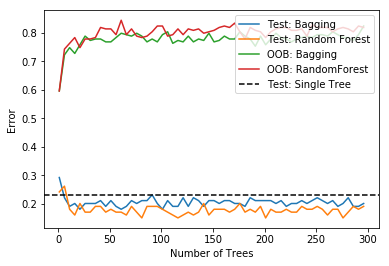

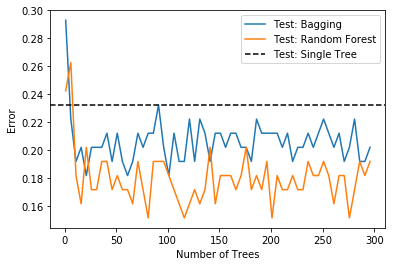

In [45]:
data = np.loadtxt('processed.cleveland.data',delimiter=',',dtype='str')
data = np.delete(data,np.where(data=='?')[0],axis=0)

X = data[:,:-1].astype(float)
y = np.clip(data[:,-1].astype(float),0,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

test_error_BG, test_error_RF = [], []
oob_BG, oob_RF = [],[]
num_trees = []
for num in range(1,300,5):
    num_trees.append(num)

    BG = RandomForestClassifier(n_estimators=num,max_features=None,oob_score=True).fit(X_train,y_train)
    RF = RandomForestClassifier(n_estimators=num,max_features="sqrt",oob_score=True).fit(X_train,y_train)
    
    test_error_BG.append(MSE(y_test,BG.predict(X_test)))
    test_error_RF.append(MSE(y_test,RF.predict(X_test)))
    oob_BG.append(BG.oob_score_)
    oob_RF.append(RF.oob_score_)

    clear_output()
    
single_tree_clf = DecisionTreeClassifier().fit(X_train,y_train)
single_tree_error = MSE(y_test,single_tree_clf.predict(X_test))

plt.figure()
plt.plot(num_trees,test_error_BG,label='Test: Bagging');
plt.plot(num_trees,test_error_RF,label='Test: Random Forest');
plt.plot(num_trees,oob_BG,label='OOB: Bagging')
plt.plot(num_trees,oob_RF,label='OOB: RandomForest')
plt.axhline(single_tree_error,color='k',linestyle='dashed',label='Test: Single Tree');
plt.xlabel('Number of Trees');
plt.ylabel('Error');
plt.legend(loc=1);

plt.figure()
plt.plot(num_trees,test_error_BG,label='Test: Bagging');
plt.plot(num_trees,test_error_RF,label='Test: Random Forest');
plt.axhline(single_tree_error,color='k',linestyle='dashed',label='Test: Single Tree');
plt.xlabel('Number of Trees');
plt.ylabel('Error');
plt.legend(loc=1);
    

## Replica figura 8.10

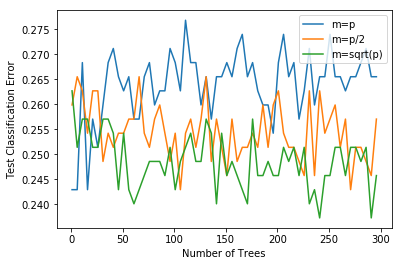

In [4]:
data = np.loadtxt('OJ.csv',delimiter=',',dtype='str')
feature2ignore = np.where(data[0,:]=='"Store7"')[0][0]
data = np.delete(data,[0,feature2ignore],axis=1)

for i,val in enumerate(data[:,0]):
    if val == '"CH"':
        data[i,0] = 1
    elif val == '"MM"':
        data[i,0] = 0

X = data[1:,1:].astype(float)
y = data[1:,0].astype(float)

n_p_half = int(X.shape[1]/2)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

error_p, error_p_half, error_p_sqrt = [], [], []
num_trees = []
for num in range(1,300,5):
    num_trees.append(num)

    p = RandomForestClassifier(n_estimators=num,max_features=None).fit(X_train,y_train)
    p_half = RandomForestClassifier(n_estimators=num,max_features=n_p_half).fit(X_train,y_train)
    p_sqrt = RandomForestClassifier(n_estimators=num,max_features="sqrt").fit(X_train,y_train)
    
    error_p.append(MSE(y_test,p.predict(X_test)))
    error_p_half.append(MSE(y_test,p_half.predict(X_test)))
    error_p_sqrt.append(MSE(y_test,p_sqrt.predict(X_test)))

    
plt.figure()
plt.plot(num_trees,error_p,label='m=p');
plt.plot(num_trees,error_p_half,label='m=p/2');
plt.plot(num_trees,error_p_sqrt,label='m=sqrt(p)');
plt.xlabel('Number of Trees');
plt.ylabel('Test Classification Error');
plt.legend(loc=1);


## Parte 2

In [39]:
def Kfold_CV(classifier, Xtrain, Ytrain, Xtest, Ytest, error_criterion='MSE'):
    K = 6
    n = len(Ytrain)
    ids = np.arange(n)
    group_ids = ids%K
    
    train_prs, val_prs, test_prs = [], [], []
    train_error, val_error, test_error = np.zeros(K), np.zeros(K), np.zeros(K)
    for i in range(K):
        ii = (group_ids==i)

        Xfit, Yfit = Xtrain[~ii,:], Ytrain[~ii]
        Xval, Yval = Xtrain[ii,:], Ytrain[ii]
        
        clf = clone(classifier,True)
        clf.fit(Xfit,Yfit)        
        clear_output()
        train_probs = clf.predict_proba(Xfit)[:,1]
        val_probs = clf.predict_proba(Xval)[:,1]
        test_probs = clf.predict_proba(Xtest)[:,1]
        
        
        train_prs.append(average_precision_score(Yfit, train_probs))
        val_prs.append(average_precision_score(Yval, val_probs))
        test_prs.append(average_precision_score(Ytest, test_probs))
        
        if(error_criterion=='MSE'):
            train_error[i] = MSE(clf.predict(Xfit),Yfit)
            val_error[i] = MSE(clf.predict(Xval),Yval)
            test_error[i] = MSE(clf.predict(Xtest),Ytest)
    
    return [[train_error], [val_error], [test_error]],  [[train_prs],[val_prs],[test_prs]]

def print_errors_and_PR(errors,PR,clf_tag):
    tags = ['Train error:','CV. error','Test error:']
    print(clf_tag)
    for i in range(3):
            print(tags[i],
                  np.round(np.array(errors[i]).mean(),4),
                  ' +-: ',np.round(np.sqrt(np.array(errors[i]).var()),4),
                  ' Precision-Recall:',np.round(np.array(PR[i]).mean(),4),
                  '+-',np.round(np.sqrt(np.array(PR[i]).var()),4))
            


In [30]:
data = np.loadtxt('OJ.csv',delimiter=',',dtype='str')
feature2ignore = np.where(data[0,:]=='"Store7"')[0][0]
data = np.delete(data,[0,feature2ignore],axis=1)


for i,val in enumerate(data[:,0]):
    if val == '"CH"':
        data[i,0] = 1
    elif val == '"MM"':
        data[i,0] = 0

X = data[1:,1:].astype(float)
y = data[1:,0].astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


## Logistic Regression

In [27]:
clf = LogisticRegression(solver='lbfgs',max_iter=1000)
errors, precision_recall = Kfold_CV(clf, X_train, y_train, X_test, y_test)
print_errors_and_PR(errors,precision_recall,'Logistic regression')

Logistic regression
Train error: 0.1578  +-:  0.0097  Precision-Recall: 0.935 +- 0.0029
CV. error 0.1648  +-:  0.013  Precision-Recall: 0.9316 +- 0.0188
Test error: 0.1897  +-:  0.0019  Precision-Recall: 0.923 +- 0.0008


## LDA

In [28]:
clf = LinearDiscriminantAnalysis()
errors, precision_recall = Kfold_CV(clf, X_train, y_train, X_test, y_test)
print_errors_and_PR(errors,precision_recall,'LDA')

LDA
Train error: 0.1483  +-:  0.0042  Precision-Recall: 0.9338 +- 0.003
CV. error 0.1564  +-:  0.0251  Precision-Recall: 0.9266 +- 0.0214
Test error: 0.1921  +-:  0.0065  Precision-Recall: 0.9228 +- 0.0029


## Random Forest
Para random forest no es necesario barrer sobre la cantidad de arboles. Teoricamente un número suficientemente grande de arboles me permite obtener un buen desempeño. En este caso se toma $n=300$ y $m=\sqrt{p}$

In [29]:
clf = RandomForestClassifier(n_estimators=300,max_features="sqrt")
errors, precision_recall = Kfold_CV(clf, X_train, y_train, X_test, y_test)
print_errors_and_PR(errors,precision_recall,'Random Forest (n_trees=300, m=sqrt(p))')

Random Forest (n_trees=300, m=sqrt(p))
Train error: 0.0061  +-:  0.0016  Precision-Recall: 0.9998 +- 0.0001
CV. error 0.1913  +-:  0.0284  Precision-Recall: 0.9174 +- 0.0219
Test error: 0.2406  +-:  0.005  Precision-Recall: 0.889 +- 0.0049


## Tree + Bagging

Para este se toma un random forest con $n=300$ y $m=p$

In [32]:
clf = RandomForestClassifier(n_estimators=300,max_features=None)
errors, precision_recall = Kfold_CV(clf, X_train, y_train, X_test, y_test)
print_errors_and_PR(errors,precision_recall,'Tree + Bagging (n_trees=300, m=p')

Tree + Bagging (n_trees=300, m=p
Train error: 0.0061  +-:  0.0016  Precision-Recall: 0.9998 +- 0.0001
CV. error 0.1829  +-:  0.035  Precision-Recall: 0.9187 +- 0.0257
Test error: 0.2538  +-:  0.006  Precision-Recall: 0.8964 +- 0.0045


## Selección de profundidad para el arbol

## CONCLUSIÓN

Observando los precision recall en Test, se concluye que el mejor clasificador está entre la regresión logistica y el LDA. El margen de error no es significativo para escoge uno de estos dos.